In [1]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
results_path = Path("/eodc/private/tuwgeo/users/mabdelaa/repos/gdacs_gfm/results")
no_aoi_path = results_path / "no_aoi"
no_data_path =  results_path / "no_data"
flood_db = Path("/eodc/private/tuwgeo/users/mabdelaa/repos/GDACS_Flood_DB/data/latest_gdacs_flood_db.csv")
results_files = [file for file in results_path.iterdir() if file.is_file()]
no_aoi_files = [file for file in no_aoi_path.iterdir() if file.is_file()]
no_data_files = [file for file in no_data_path.iterdir() if file.is_file()]
df = pd.read_csv(flood_db)
df = df.drop(columns=['Unnamed: 0'])

In [2]:
def get_area_max(file_path):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates()
    return max(df['area_km2'])

In [3]:
results_df = df[['GDACS_ID']].copy()  
results_df['status'] = ""
results_df['ensemble'] = ""
results_df['tuw'] = ""
results_df['list'] = ""
results_df['dlr'] = ""
results_df["GDACS_ID"] = results_df["GDACS_ID"].astype(str)
results_df = results_df.set_index("GDACS_ID")


In [ ]:
reprocess = {"ensemble":[],
             "tuw":[], 
             "list":[],
             "dlr":[]}

for file_path in tqdm(no_aoi_files, total=len(no_aoi_files), unit="Event"):
    event_id = file_path.stem
    if event_id in results_df.index:
            results_df.loc[event_id, "status"] = "no_aoi"

for file_path in tqdm(no_data_files, total=len(no_data_files), unit="Event"):
    event_id = file_path.stem
    if event_id in results_df.index:
            results_df.loc[event_id, "status"] = "no_data"
            
for file_path in tqdm(results_files, total=len(results_files), unit="Event"):
    event_id, algo = file_path.stem.split("_", 1)

    if event_id.startswith("FL"):
        try:
            max_area = get_area_max(file_path)

            if event_id in results_df.index:
                results_df.loc[event_id, algo] = max_area
                results_df.loc[event_id, "status"] = "Processed"
            
        except Exception as e:
            print(event_id, algo)
            print(e)
            algo = algo.split("_")[0]
            reprocess[algo].append(event_id)




  0%|          | 0/222 [00:00<?, ?Event/s]

100%|██████████| 13697/13697 [00:57<00:00, 240.01Event/s]


In [15]:
no_aoi_df = results_df[results_df['status']=="no_aoi"]
no_aoi_df = no_aoi_df.drop(columns=['ensemble','tuw','list','dlr'])
no_data_df = results_df[results_df['status']=="no_data"]
no_data_df = no_data_df.drop(columns=['ensemble','tuw','list','dlr'])
processed_df = results_df[results_df['status']=="Processed"]

no_aoi_df = no_aoi_df.merge(
    df, 
    left_index = True,
    right_on = "GDACS_ID",
    how="left"
)
no_data_df = no_data_df.merge(
    df, 
    left_index=True,
    right_on="GDACS_ID",
    how="left"
)

processed_df = processed_df.merge(
    df, 
    left_index=True,
    right_on ="GDACS_ID",
    how="left"
)

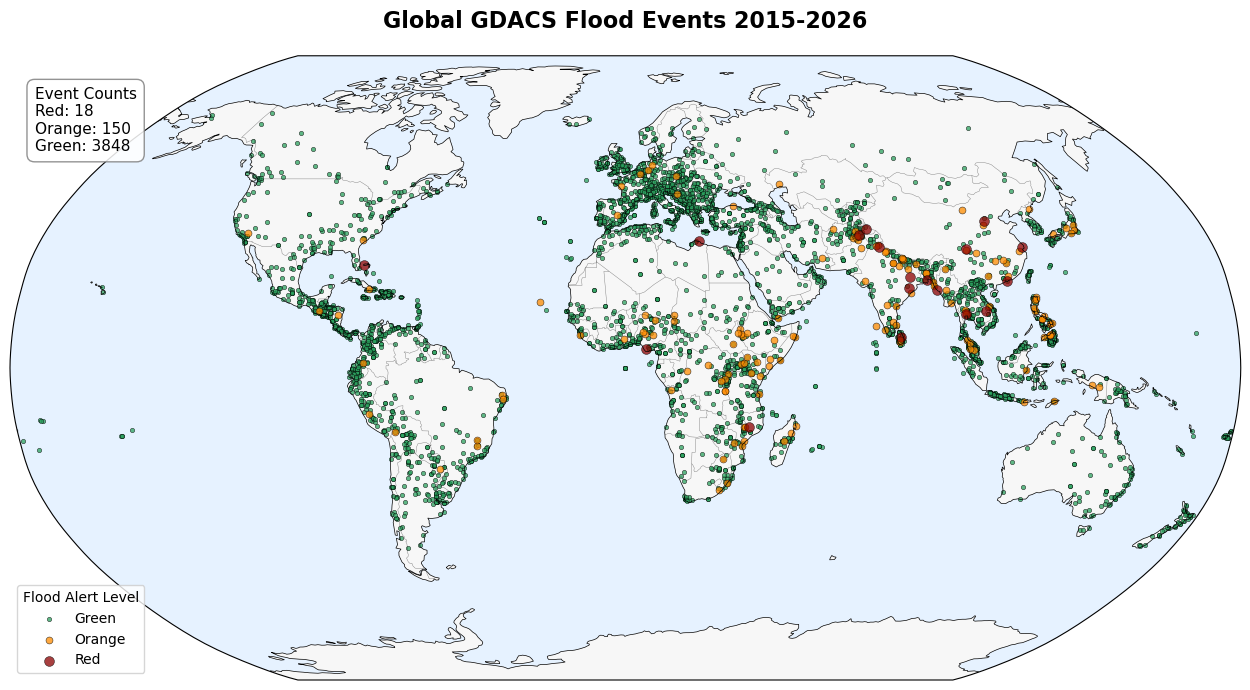

In [20]:
import pandas as pd
import ast
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig_save_path = Path("/eodc/private/tuwgeo/users/mabdelaa/repos/gdacs_gfm/figures")

SIZE_MAP = {
    "red": 50,
    "orange": 25,
    "green": 10
}

COLOR_MAP = {
    "red": "#8b0000",
    "orange": "#ff8c00",
    "green": "#2ca25f"
}

# Normalize alert level naming
df["alertlevel"] = df["alertlevel"].str.lower()

# Convert geometry string to dict
df["geometry_dict"] = df["geometry"].apply(ast.literal_eval)

# Extract coordinates
df["lon"] = df["geometry_dict"].apply(lambda x: x["coordinates"][0])
df["lat"] = df["geometry_dict"].apply(lambda x: x["coordinates"][1])

# Count events per alert level
counts = df["alertlevel"].value_counts().to_dict()

red_count = counts.get("red", 0)
orange_count = counts.get("orange", 0)
green_count = counts.get("green", 0)


# -------------------------
# Create map
# -------------------------
plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor="#e6f2ff")
ax.add_feature(cfeature.LAND, facecolor="#f7f7f7")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)

# Plot events
for level in ["green", "orange", "red"]:
    subset = df[df["alertlevel"] == level]

    ax.scatter(
        subset["lon"],
        subset["lat"],
        s=SIZE_MAP[level],
        color=COLOR_MAP[level],
        alpha=0.75,
        edgecolor="black",
        linewidth=0.4,
        transform=ccrs.PlateCarree(),
        label=level.capitalize()
    )

# Legend
plt.legend(title="Flood Alert Level", loc="lower left", frameon=True)

# -------------------------
# Add count annotation
# -------------------------
text = (
    f"Event Counts\n"
    f"Red: {red_count}\n"
    f"Orange: {orange_count}\n"
    f"Green: {green_count}"
)

plt.text(
    0.02, 0.95,
    text,
    transform=ax.transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.85,
        edgecolor="gray"
    )
)

# Title
plt.title("Global GDACS Flood Events 2015-2026", fontsize=16, weight="bold", pad=20)
fig = fig_save_path/"global_flood_map.png"
plt.tight_layout()
plt.savefig(fig, dpi=300, bbox_inches="tight")
plt.show()